In [57]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tqdm import tqdm


class RB():
    def __init__(self):
        self.buffer = {"outcomes":[],"actions":[],"reward":[]}
        
    def add(self, state, reward):
        self.buffer["outcomes"].append(state["outcomes"])
        self.buffer["actions"].append(state["betas"])
        self.buffer["reward"].append(reward)
   
    def delete_items(self, cut_first_items=10, cut_random=50):
        for i in self.buffer.keys()
            self.buffer[i] = self.buffer[i][cut_first_items:]
        random_indexes = np.random.choice(range(len(self.buffer[i])), cut_random)
        for i in self.buffer.keys():
            for j in random_indexes:
                self.buffer[i].remove(self.buffer[i][j])
        return

class Critic(tf.keras.Model):
    def __init__(self, layer=0):
        super(Critic, self).__init__()
        self.l1 = Dense(100, input_shape=(1,), kernel_initializer='random_uniform',
                bias_initializer='random_uniform')
        self.l2 = Dense(250, kernel_initializer='random_uniform',
                bias_initializer='random_uniform')
        self.l3 = Dense(1, kernel_initializer='random_uniform',
                bias_initializer='random_uniform')

        self.loss = tf.keras.losses.MeanSquaredError()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

    def call(self, input):
        state, action = input
        features = tf.concat([state, action], axis=1)
        feat = tf.nn.relu(self.l1(features))
        feat = tf.nn.relu(self.l2(feat))
        value = self.l3(feat)
        return tf.nn.tanh(value)*2 #Tanh image is [-1,1]

    @tf.function
    def step_critic(self,labels, states):
        #Takes as input [ [ array_of_[states]  ]  , [ array_of_ [actions]  ]  ]
        #and labels = np.array(N=len(array_of_[states]=len_array_of_[actions]))
        with tf.GradientTape() as tape:
            l = self.loss(labels, self.call(states))
            l = tf.reduce_mean(l)
        g = tape.gradient(l, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        return



class Actor(tf.keras.Model):
    def __init__(self, layer=0):
        super(Actor,self).__init__()
        self.l1 = Dense(200, input_shape=(1,), kernel_initializer='random_uniform',
                bias_initializer='random_uniform')
        self.l2 = Dense(250, kernel_initializer='random_uniform',
                bias_initializer='random_uniform')
        self.l3 = Dense(1, kernel_initializer='random_uniform',
                bias_initializer='random_uniform')

        self.loss = tf.keras.losses.MeanSquaredError()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

    def call(self, input):
        feat = tf.nn.relu(self.l1(input))
        feat = tf.nn.relu(self.l2(feat))
        action = tf.nn.relu(self.l3(feat))
        return tf.nn.tanh(action)*2 #Tanh image is [-1,1]


    @tf.function
    def step_actor(labels):
        #Takes as input np.array(whatever)[...,tf.newaxis]
        dummy_states = np.zeros(len(labels))[...,tf.newaxis]
        with tf.GradientTape() as tape:
            l = loss_mse(labels, pol(dummy_states))
            l = tf.reduce_mean(l)
        grad = tape.gradient(l,pol.trainable_variables)
        optimizer.apply_gradients(zip(grad, pol.trainable_variables))
        return

def P(a,beta,n):
    p = np.exp(-(a-beta)**2)
    if n==0:
        return p
    else:
        return 1-p

def give_beta():
    input_dummy = np.array([0.])[...,tf.newaxis]
    beta = network(input_dummy)
    return beta + tf.random.normal(shape=beta.shape, mean=0., stddev = .25, dtype=tf.float64)

def make_bet(outcome, beta):
    # guess = NN_guess(state)
    phases=[-1,1]
    guess = np.argmax([P(ph*amplitude, beta, outcome) for ph in phases])
    return phases[guess]

def obtain_reward(outcome, beta, message):
    opinion = make_bet(outcome, beta)
    if opinion==message:
        return 1
    else:
        return 0


@tf.function
def step_learn_actor_ddpg(states_actions):
    with tf.GradientTape() as tape:
        policy_value = actor(np.zeros(len(states_actions[0]))[...,tf.newaxis])
        q_values = critic(states_actions)
        product = tf.multiply(policy_value, q_values)
        actor_loss = -tf.reduce_mean(product) # This is intended to be \sum_n \dev Q(s,a) \def \mu
    g = tape.gradient(actor_loss, actor.trainable_variables)
    actor.optimizer.apply_gradients(zip(g,actor.trainable_variables))
    return


amplitude=.56
layers=1
buffer_simpler = []
critic = Critic()
actor = Actor()
def body(states_wasted=10):
    for experiments in tqdm(range(states_wasted)):
        message = np.random.choice([-1,1],1)[0]
        # state={"outcomes":[], "betas":[]}
        for layer in range(layers): #in this case one round
            # beta_tf = give_beta(actor)
            beta_tf = actor(np.array([0.])[...,tf.newaxis])
            beta = beta_tf.numpy().flatten()[0]
            beta = np.float64(beta)
            outcome = np.random.choice([0,1],1,p=[P(message*amplitude, beta, n) for n in [0,1]])[0]
            outcome = np.float64(outcome)
            # state["outcomes"].append(outcome)
            # state["betas"].append(beta)
        reward = obtain_reward(outcome,beta, message)
        #buffer.add(state, reward)
        buffer_simpler.append([beta, outcome, reward])
        
        q_value_critic = critic([ [ [outcome] ] , [ [beta] ] ])
        if len(buffer_simpler)<100:
            pass
        else:
            # td_errors = []
            states_actions = [[], []]
            labels = []
            if experiments%10 ==0:
                index_to_sample = np.random.choice(range(len(buffer_simpler)),100)
                for index in index_to_sample:
                    sample = buffer_simpler[index]
                    labels.append(sample[2])
                    states_actions[0].append([sample[1]])
                    states_actions[1].append([sample[0]]) #notice it's important to have

                critic.step_critic(labels, states_actions)
                step_learn_actor_ddpg(states_actions)


#


In [58]:
body(500)


  0%|          | 0/500 [00:00<?, ?it/s]

ValueError: tf.function-decorated function tried to create variables on non-first call.

In [47]:
actor(np.array([0.])[...,tf.newaxis])

<tf.Tensor: id=265085, shape=(1, 1), dtype=float64, numpy=array([[0.]])>

In [48]:
for i in actor.trainable_variables:
    print(i.numpy())

[[-0.01761364  0.02604751]]
[-0.02297472 -0.01298115]
[[ 0.04186922 -0.04876846]
 [ 0.04200366  0.04916233]]
[-0.00999389 -0.0405456 ]
[[-0.00559777]
 [-0.03501129]]
[-0.01143693]


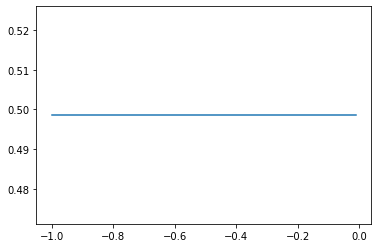

In [54]:
q=[]
for i in np.arange(-1,0,.01):
    q.append(critic([ [ [0.] ], [ [i]]]).numpy().flatten()[0])
    
import matplotlib.pyplot as plt
plt.plot(np.arange(-1,0,.01),q)